Aim:
Finding a suitable model for classification of leukemic B-lymphoblast cells from normal B-lymphoid precursors from blood smear microscopic images. 

We have used a CNN model and some pretrained models like ResNet50, VGG16, VGG19 and InceptionV3 in this process.
After training the models for 15 epochs, the VGG19 model came up with the highest accuracy among all of them with about ~78% accuracy and VGG16 was the second highest with a little less accuracy than the former with about ~77%.

The reason behind VGG models getting so much higher accuracy in comparison to others is its architecture, the main key points of this architecture are as follows: 

*    Use of very small convolutional filters, e.g. 3×3 and 1×1 with a stride of one.
*    Use of max pooling with a size of 2×2 and a stride of the same dimensions.
*    The importance of stacking convolutional layers together before using a pooling layer to define a block.
*    Dramatic repetition of the convolutional-pooling block pattern.
*    Development of very deep (16 and 19 layer) models.




In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
# Any results you write to the current directory are saved as output.

['c-nmc_test_prelim_phase_data']


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob
%matplotlib inline
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix

import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, DepthwiseConv2D
from keras import backend as K
import itertools
from keras.optimizers import Adam, sgd
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


In [3]:
os.listdir("../input")

['c-nmc_test_prelim_phase_data']

In [4]:
data = pd.read_csv("../input/c-nmc_test_prelim_phase_data/C-NMC_test_prelim_phase_data/C-NMC_test_prelim_phase_data_labels.csv")
data.head()

,Patient_ID,new_names,labels
0,UID_57_29_1_all.bmp,1.bmp,1
1,UID_57_22_2_all.bmp,2.bmp,1
2,UID_57_31_3_all.bmp,3.bmp,1
3,UID_H49_35_1_hem.bmp,4.bmp,0
4,UID_58_6_13_all.bmp,5.bmp,1


## Preprocessing the data

In [5]:
baseadd = "../input/c-nmc_test_prelim_phase_data/C-NMC_test_prelim_phase_data/C-NMC_test_prelim_phase_data"
image_path_dict = {os.path.basename(x): x for x in glob(os.path.join(baseadd, "*.bmp"))}
data["path"] = (data["new_names"]).map(image_path_dict.get)
data['image'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((224, 224))))
data["image"].shape

(1867,)

(-0.5, 223.5, 223.5, -0.5)

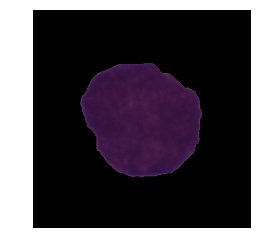

In [6]:
plt.imshow(data["image"][0])
plt.axis("off")

In [7]:
data["Patient_ID"][0].split('_')
subject_id_dict = {data["Patient_ID"][x]: data["Patient_ID"][x].split("_")[1] for x in range(len(data["Patient_ID"]))}
image_id_dict = {data["Patient_ID"][x]: data["Patient_ID"][x].split("_")[2] for x in range(len(data["Patient_ID"]))}
cell_id_dict = {data["Patient_ID"][x]: data["Patient_ID"][x].split("_")[3] for x in range(len(data["Patient_ID"]))}

In [8]:
data["subject_id"] = data["Patient_ID"].map(subject_id_dict.get)
data["image_id"] = data["Patient_ID"].map(image_id_dict.get)
data["cell_no"] = data["Patient_ID"].map(cell_id_dict.get)
# data["cell_state"] = data["Patient_ID"].map(cell_type_id_dict.get)
data.sample()

,Patient_ID,new_names,labels,path,image,subject_id,image_id,cell_no
0,UID_57_29_1_all.bmp,1.bmp,1,../input/c-nmc_test_prelim_phase_data/C-NMC_te...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",57,29,1
1,UID_57_22_2_all.bmp,2.bmp,1,../input/c-nmc_test_prelim_phase_data/C-NMC_te...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",57,22,2
2,UID_57_31_3_all.bmp,3.bmp,1,../input/c-nmc_test_prelim_phase_data/C-NMC_te...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",57,31,3
3,UID_H49_35_1_hem.bmp,4.bmp,0,../input/c-nmc_test_prelim_phase_data/C-NMC_te...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",H49,35,1
4,UID_58_6_13_all.bmp,5.bmp,1,../input/c-nmc_test_prelim_phase_data/C-NMC_te...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",58,6,13


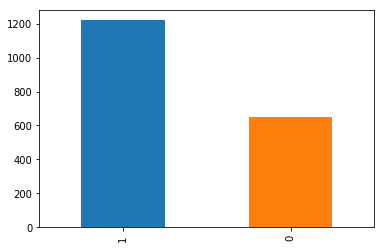

In [9]:
data["labels"].value_counts().plot(kind = "bar")

In [10]:
X = data.drop(["labels"], axis = 1)
y = data["labels"]

In [11]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Normalization
x_train = np.asarray(x_train['image'].tolist())
x_test = np.asarray(x_test['image'].tolist())

x_train_mean = np.mean(x_train)
x_test_mean = np.mean(x_test)

x_train_std = np.std(x_train)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

# Label Encoding
y_train = to_categorical(y_train, num_classes = 2)
y_test = to_categorical(y_test, num_classes = 2)

# Reshape images in 3 dimensions
x_train = x_train.reshape(x_train.shape[0], *(224, 224, 3))
x_test = x_test.reshape(x_test.shape[0], *(224, 224, 3))

## Defining models to train on our dataset

In [12]:
# Set CNN model
# Our system of layers => [[Conv2D -> relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense
# -> Dropout -> Out
input_shape = (224, 224, 3)
num_classes = 2

model = Sequential()
model.add(Conv2D(32, kernel_size = (3, 3), activation = 'relu', padding = 'Same', input_shape = input_shape))
model.add(Conv2D(32, kernel_size = (3, 3), activation = 'relu', padding = 'Same'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu', padding = 'Same'))
model.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu', padding = 'Same'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
conv2d_4 (Conv2D)    

### Fitting our CNN model

In [13]:
# Set learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_acc', patience = 3, verbose = 1, 
                                           factor = 0.5, min_lr = 0.00001)

# Data Augmentation
datagen = ImageDataGenerator(featurewise_center = False, samplewise_center = False,
                            featurewise_std_normalization = False, samplewise_std_normalization = False, 
                            zca_whitening = False, rotation_range = 10, zoom_range = 0.1, 
                            width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = False, 
                            vertical_flip = False)
datagen.fit(x_train)

# Define the optimizer
optimizer = Adam(lr = .001, beta_1 = .9, beta_2 = .999, epsilon = None, decay = .0, amsgrad = False)

# Fit the model
epochs = 15
batch_size = 80

# Compile CNN model
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])
print("*"*40 + "CNN model" + "*"*40)
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size = batch_size), 
                             epochs = epochs, verbose = 1, steps_per_epoch = x_train.shape[0] // batch_size,
                             validation_data = (x_test, y_test))

****************************************CNN model****************************************
Instructions for updating:
Use tf.cast instead.
Epoch 1/15
18/18 [==============================] - 18s 996ms/step - loss: 5.3444 - acc: 0.6431 - val_loss: 5.8180 - val_acc: 0.6390
Epoch 2/15
18/18 [==============================] - 14s 782ms/step - loss: 5.6484 - acc: 0.6496 - val_loss: 5.8180 - val_acc: 0.6390
Epoch 3/15
18/18 [==============================] - 14s 789ms/step - loss: 5.5086 - acc: 0.6582 - val_loss: 5.8180 - val_acc: 0.6390
Epoch 4/15
18/18 [==============================] - 14s 782ms/step - loss: 5.6878 - acc: 0.6471 - val_loss: 5.8180 - val_acc: 0.6390
Epoch 5/15
18/18 [==============================] - 14s 782ms/step - loss: 5.4487 - acc: 0.6619 - val_loss: 5.8180 - val_acc: 0.6390
Epoch 6/15
18/18 [==============================] - 14s 777ms/step - loss: 5.2613 - acc: 0.6736 - val_loss: 5.8180 - val_acc: 0.6390
Epoch 7/15
18/18 [==============================] - 14s 780ms/st

### Fitting our pretrained models

In [14]:
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from tensorflow.python.keras.applications import ResNet50, VGG16, VGG19, InceptionV3
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping

In [15]:
# Using pretrained models for VGG16, VGG19, resnet, InceptionV3
# If you are using Kaggle kernel, do switch ON the Internet from Settings.
model_resnet = Sequential()
model_resnet.add(ResNet50(include_top=False, pooling='max', weights= "imagenet"))
model_resnet.add(Dense(num_classes, activation='softmax'))

model_vgg16 = Sequential()
model_vgg16.add(VGG16(include_top= False, pooling = "max", weights = "imagenet"))
model_vgg16.add(Dense(num_classes, activation = "softmax"))

model_vgg19 = Sequential()
model_vgg19.add(VGG19(include_top= False, pooling = "max", weights = "imagenet"))
model_vgg19.add(Dense(num_classes, activation = "softmax"))

model_inception = Sequential()
model_inception.add(InceptionV3(include_top= False, pooling = "max", weights = "imagenet"))
model_inception.add(Dense(num_classes, activation = "softmax"))

# Say not to train first layer (ResNet) model. It is already trained
model_resnet.layers[0].trainable = False
model_vgg16.layers[0].trainable = False
model_vgg19.layers[0].trainable = False
model_inception.layers[0].trainable = False

87916544/87910968 [==============================] - 1s 0us/step


In [16]:
# Compile the pretrained models
model_resnet.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

model_vgg16.compile(optimizer = 'sgd', loss = "categorical_crossentropy", metrics = ['accuracy'])

model_vgg19.compile(optimizer = 'sgd', loss = "categorical_crossentropy", metrics = ['accuracy'])

model_inception.compile(optimizer = 'sgd', loss = "categorical_crossentropy", metrics = ['accuracy'])

In [17]:
# Fit the model
print("*"*40 + "ResNet50 model" + "*"*40)
history = model_resnet.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                           verbose = 0,
                           epochs = epochs,
                           steps_per_epoch=x_train.shape[0] // batch_size,
                           validation_data = (x_test, y_test))
print("*"*40 + "VGG16 model" + "*"*40)
history = model_vgg16.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                           verbose = 0,
                           epochs = epochs,
                           steps_per_epoch=x_train.shape[0] // batch_size,
                           validation_data = (x_test, y_test))

print("*"*40 + "VGG19 model" + "*"*40)
history = model_vgg19.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                           verbose = 0,
                           epochs = epochs,
                           steps_per_epoch=x_train.shape[0] // batch_size,
                           validation_data = (x_test, y_test))

print("*"*40 + "inception model" + "*"*40)
history = model_inception.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                           verbose = 0,
                           epochs = epochs,
                           steps_per_epoch=x_train.shape[0] // batch_size,
                           validation_data = (x_test, y_test))

****************************************ResNet50 model****************************************
374/374 [==============================] - 1s 3ms/sample - loss: 5.8389 - acc: 0.6390
****************************************VGG16 model****************************************
374/374 [==============================] - 1s 3ms/sample - loss: 0.5112 - acc: 0.7754
****************************************VGG19 model****************************************
374/374 [==============================] - 1s 4ms/sample - loss: 0.5404 - acc: 0.7888
****************************************inception model****************************************
374/374 [==============================] - 1s 3ms/sample - loss: 5.8389 - acc: 0.6390
